# Sentiment Analysis using LSTM

Resource: https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

Predict if a movie review is positive or not.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_valid_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## 1. Data

We will use the IMDB movie reviews dataset

In [3]:
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
#uploaded = files.upload() upload only ones
#! gdown --id 1U7tXjHtUdJRNi0ZZe7cKgqhT12Op7phL #faster: upload to the google drive and share it
base_csv = '/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv' # review and sentiment pares
df = pd.read_csv(base_csv)
df.head()

Mounted at /content/drive


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Spilitting to train and validation

In [4]:
X, y = df['review'].values, df['sentiment'].values # separate the input and output

x_train,x_valid,y_train,y_valid = train_valid_split(X,y,stratify=y) # split the data into a train and validation set ,stratify: keep the original ratio of the classes in the train set
print(f'shape of train data is {x_train.shape}')
print(f'shape of valid data is {x_valid.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


#### Data ballance check

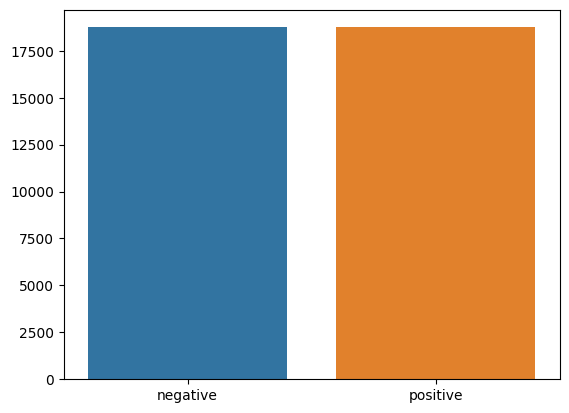

In [5]:
dd = pd.Series(y_train).value_counts() #check the ratio of the classes
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

#### Tockenization

In [6]:
import nltk  #Natural Language Toolkit
nltk.download('stopwords') #downloading only the stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space atches Unicode whitespace characters (which includes [ \t\n\r\f\v], and also many other characters, for example the non-breaking spaces mandated by typography rules in many languages)
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split(): #change to lowercase and cut to words
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    #A counter is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.
    corpus = Counter(word_list)
    # sorting on the basis of most common words (1000)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    # creating a dict
    integer_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_valid = [],[]
    for sent in x_train:
            final_list_train.append([integer_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in integer_dict.keys()])                    # convert you string to lower-case first, then split
    for sent in x_val:
            final_list_valid.append([integer_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in integer_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_valid = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_valid), np.array(encoded_valid),integer_dict

In [8]:
x_train,y_train,x_valid,y_valid,vocab = tockenize(x_train,y_train,x_valid,y_valid)

<ipython-input-7-3aeb74bb39a5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),integer_dict


In [9]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 2000


In [10]:
vocab

{'br': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'good': 6,
 'even': 7,
 'would': 8,
 'time': 9,
 'really': 10,
 'see': 11,
 'story': 12,
 'much': 13,
 'well': 14,
 'get': 15,
 'great': 16,
 'also': 17,
 'bad': 18,
 'people': 19,
 'first': 20,
 'dont': 21,
 'movies': 22,
 'make': 23,
 'made': 24,
 'could': 25,
 'way': 26,
 'films': 27,
 'characters': 28,
 'think': 29,
 'watch': 30,
 'many': 31,
 'seen': 32,
 'two': 33,
 'character': 34,
 'never': 35,
 'love': 36,
 'plot': 37,
 'acting': 38,
 'best': 39,
 'little': 40,
 'know': 41,
 'show': 42,
 'life': 43,
 'ever': 44,
 'better': 45,
 'still': 46,
 'scene': 47,
 'say': 48,
 'end': 49,
 'man': 50,
 'scenes': 51,
 'something': 52,
 'go': 53,
 'im': 54,
 'back': 55,
 'watching': 56,
 'real': 57,
 'thing': 58,
 'doesnt': 59,
 'didnt': 60,
 'actors': 61,
 'years': 62,
 'another': 63,
 'though': 64,
 'actually': 65,
 'funny': 66,
 'makes': 67,
 'nothing': 68,
 'look': 69,
 'work': 70,
 'find': 71,
 'going': 72,
 'lot': 73,
 'every'

In [11]:
print("Example X size:",len(x_train[0]))
print("Example X:",x_train[0])
print("Example Y:",y_train[0])

Example X size: 61
Example X: [16, 160, 1354, 122, 85, 152, 668, 36, 155, 1366, 607, 54, 57, 211, 132, 371, 1347, 326, 1171, 46, 1139, 33, 46, 16, 1030, 190, 576, 82, 6, 14, 201, 275, 24, 1607, 312, 1074, 36, 138, 3, 607, 782, 107, 154, 1348, 120, 137, 533, 3, 17, 154, 405, 36, 149, 3, 17, 275, 251, 3, 419, 16, 1699]
Example Y: 1


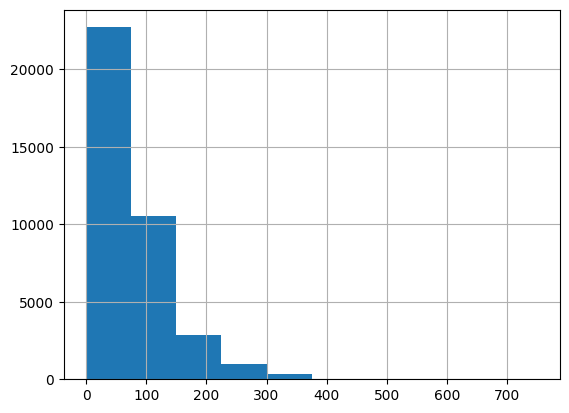

count    37500.000000
mean        82.160480
std         57.960273
min          0.000000
25%         46.000000
50%         63.000000
75%        100.000000
max        750.000000
dtype: float64

In [12]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

#### Padding
We will pad each of the sequences to a max length

In [13]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

#we have very less number of reviews with length > 500.
#So we will consider only those below it.
x_train_pad = padding_(x_train,500)
x_valid_pad = padding_(x_valid,500)

#### Batching and loading as tensor

In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid_pad), torch.from_numpy(y_valid))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[   0,    0,    0,  ...,  477,  330,  118],
        [   0,    0,    0,  ...,  485,   69,  703],
        [   0,    0,    0,  ...,    3, 1373,  330],
        ...,
        [   0,    0,    0,  ..., 1044,  200,  101],
        [   0,    0,    0,  ...,  703,  850,   14],
        [   0,    0,    0,  ...,  349,   14,  248]])
Sample output: 
 tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

## 2. Model

We are going to create something SIMILAR to this:
![](https://miro.medium.com/max/1400/1*SICYykT7ybua1gVJDNlajw.png)

In [16]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden



In [17]:
no_layers = 5
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 256, num_layers=5, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## 3. Training

In [18]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [19]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')


Epoch 1
train_loss : 0.692730417172114 val_loss : 0.6934789879322052
train_accuracy : 50.61866666666667 val_accuracy : 50.0
Validation loss decreased (inf --> 0.693479).  Saving model ...
Epoch 2
train_loss : 0.6932832315762838 val_loss : 0.6932202475070953
train_accuracy : 50.104000000000006 val_accuracy : 50.0
Validation loss decreased (0.693479 --> 0.693220).  Saving model ...
Epoch 3
train_loss : 0.6932238628864288 val_loss : 0.6932772314548492
train_accuracy : 50.10133333333333 val_accuracy : 50.0
Epoch 4
train_loss : 0.6932673753102621 val_loss : 0.6931663179397582
train_accuracy : 49.848 val_accuracy : 50.0
Validation loss decreased (0.693220 --> 0.693166).  Saving model ...
Epoch 5
train_loss : 0.6932185967763265 val_loss : 0.6933338708877563
train_accuracy : 49.962666666666664 val_accuracy : 50.0
Epoch 6
train_loss : 0.6932388188838958 val_loss : 0.6932497627735138
train_accuracy : 49.848 val_accuracy : 50.0
Epoch 7
train_loss : 0.6932646340529124 val_loss : 0.6931634051799774

## 4. Results

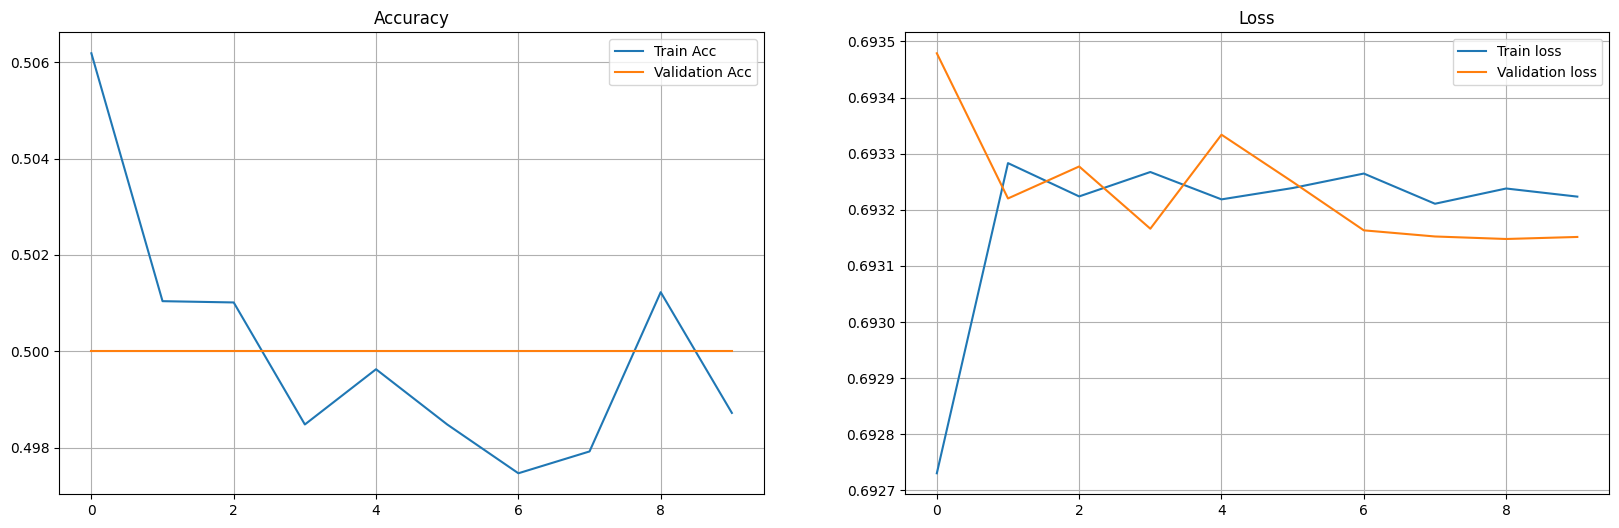

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

## 5. Inference

In [21]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

### Try an example from our data

In [22]:
index = 100
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious piece that contends against similar cartoons yielding multiple writers. The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons. This premise allows for some funny content near the beginning, but is barely present for the remainder of the feature. This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number. Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show. But it's surely follows it plot better than many high-budget Hollywood films. This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story.
Actual sentiment is  : positive
Predicted sentiment is negative with a probability of 0.5015045404434204


In [23]:
index = 40
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

It had all the clichés of movies of this type and no substance. The plot went nowhere and at the end of the movie I felt like a sucker for watching it. The production was good; however, the script and acting were B-movie quality. The casting was poor because there were good actors mixed in with crumby actors. The good actors didn't hold their own nor did they lift up the others. <br /><br />This movie is not worthy of more words, but I will say more to meet the minimum requirement of ten lines. James Wood and Cuba Gooding, Jr. play caricatures of themselves in other movies. <br /><br />If you are looking for mindless entertainment, I still wouldn't recommend this movie.
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.5015044212341309


## Test with any example

In [24]:
input = "It was not great."
print(input)
print('='*70)
pro = predict_text(input)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

It was not great.
Predicted sentiment is negative with a probability of 0.500908613204956


## Next steps

Some improvement suggestions are as follow:

Running a hyperparameter search to optimize your configurations.

Using pretraned word embeddings like Glove word embeddings

Increasing the model complexity like adding more layers/ using bidirectional LSTMs